В данном процессе моделирования используются 5 моделей машинного обучения для решения двух разных задач.

1. Определение вида оборудования (Equipment type Model):
Первая модель принимает на вход звуковые данные, записанные на микрофоны с различных типов оборудования. Она использует алгоритм CatBoostClassifier, чтобы классифицировать звук и определить, с какого оборудования он был записан.
2. Определение аномальности звука (Anomaly Models):
После того как первая модель определила вид оборудования, звуковые данные передаются в одну из четырех моделей (по одной на каждый тип оборудования - в данном случае клапаны, насосы, вентиляторы и направляющие). Эти модели отвечают за анализ звука на предмет аномалий. Они также используют алгоритм  CatBoostClassifier, чтобы выявить отклонения от нормального поведения звука, которые могут указывать на неисправности или другие проблемы.

# Equioment type Model

In [ ]:
!pip install noisereduce

In [ ]:
!pip install catboost

In [ ]:
!pip install pydub

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import noisereduce as nr
from pydub import AudioSegment
from pydub.effects import normalize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.signal import welch
from sklearn.metrics import classification_report

Первая модель обучена на моноканальных данных, так как тип оборудования при обучении будет не известен

In [22]:
data = pd.read_csv('data_mono.csv')
data.head()

,db,chanel,id,is_norm,file_name,mel1,mel2,mel3,mel4,mel5,...,psd120,psd121,psd122,psd123,psd124,psd125,psd126,psd127,psd128,psd129
0,db-6,4,id_00,0,00000000.wav,-46.456806,-46.578846,-48.761510,-48.653366,-48.911167,...,1.364821e-22,1.541437e-22,2.333787e-22,4.929646e-22,1.532547e-21,1.018071e-20,1.496497e-19,5.204051e-19,2.707182e-18,4.208603e-18
1,db-6,4,id_00,0,00000001.wav,-44.225758,-43.535175,-44.278908,-44.468216,-45.288220,...,4.293508e-23,3.845343e-23,3.480267e-23,3.705355e-23,5.557365e-23,2.047138e-22,2.587547e-21,9.112180e-21,4.729534e-20,7.342920e-20
2,db-6,4,id_00,0,00000002.wav,-47.693497,-50.621190,-47.872574,-46.445210,-46.472720,...,6.948789e-22,6.327302e-22,6.072445e-22,6.105096e-22,7.996011e-22,2.535504e-21,3.137859e-20,1.078250e-19,5.563325e-19,8.612460e-19
3,db-6,4,id_00,0,00000003.wav,-41.196163,-46.054543,-46.963690,-46.137030,-49.785816,...,2.006051e-23,2.068714e-23,2.346858e-23,5.382465e-23,1.525744e-22,9.655351e-22,1.458144e-20,5.050775e-20,2.648138e-19,4.115827e-19
4,db-6,4,id_00,0,00000004.wav,-41.935684,-45.101200,-42.961277,-41.684372,-41.640370,...,4.692184e-22,4.224302e-22,4.012274e-22,4.378610e-22,7.154497e-22,3.081797e-21,4.144176e-20,1.410821e-19,7.285133e-19,1.131496e-18


In [23]:
df = pd.DataFrame(data)

df = df.drop(columns=['db', 'id', 'file_name', 'is_norm'])

In [24]:
df['chanel'] = df['chanel'].astype(np.uint8) / 2

In [25]:
df

,chanel,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,mel9,...,psd120,psd121,psd122,psd123,psd124,psd125,psd126,psd127,psd128,psd129
0,2.0,-46.456806,-46.578846,-48.761510,-48.653366,-48.911167,-46.321510,-49.737526,-52.872750,-54.858280,...,1.364821e-22,1.541437e-22,2.333787e-22,4.929646e-22,1.532547e-21,1.018071e-20,1.496497e-19,5.204051e-19,2.707182e-18,4.208603e-18
1,2.0,-44.225758,-43.535175,-44.278908,-44.468216,-45.288220,-46.220093,-43.773357,-45.187084,-40.110290,...,4.293508e-23,3.845343e-23,3.480267e-23,3.705355e-23,5.557365e-23,2.047138e-22,2.587547e-21,9.112180e-21,4.729534e-20,7.342920e-20
2,2.0,-47.693497,-50.621190,-47.872574,-46.445210,-46.472720,-45.842228,-45.380474,-48.271480,-49.443040,...,6.948789e-22,6.327302e-22,6.072445e-22,6.105096e-22,7.996011e-22,2.535504e-21,3.137859e-20,1.078250e-19,5.563325e-19,8.612460e-19
3,2.0,-41.196163,-46.054543,-46.963690,-46.137030,-49.785816,-50.619263,-49.360283,-50.372135,-52.959198,...,2.006051e-23,2.068714e-23,2.346858e-23,5.382465e-23,1.525744e-22,9.655351e-22,1.458144e-20,5.050775e-20,2.648138e-19,4.115827e-19
4,2.0,-41.935684,-45.101200,-42.961277,-41.684372,-41.640370,-41.523888,-42.465454,-41.976925,-43.022140,...,4.692184e-22,4.224302e-22,4.012274e-22,4.378610e-22,7.154497e-22,3.081797e-21,4.144176e-20,1.410821e-19,7.285133e-19,1.131496e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36033,0.0,-42.001453,-43.320522,-45.312836,-45.904858,-48.341442,-50.228493,-50.873905,-52.480230,-54.614243,...,1.018302e-19,9.025174e-20,8.095798e-20,7.357146e-20,6.768529e-20,6.313280e-20,5.982809e-20,5.752919e-20,5.738387e-20,3.008743e-20
36034,0.0,-38.113914,-38.850910,-42.880955,-46.386555,-47.690346,-50.747154,-52.818707,-53.889220,-53.752945,...,2.640146e-20,2.289271e-20,2.007196e-20,1.783108e-20,1.608786e-20,1.521414e-20,2.129337e-20,3.939098e-20,1.576976e-19,2.349197e-19
36035,0.0,-50.363354,-49.536587,-51.767265,-55.867813,-57.583508,-57.484547,-54.879627,-51.151333,-51.228928,...,2.433849e-20,2.080000e-20,1.798752e-20,1.580435e-20,1.419819e-20,1.408084e-20,3.254447e-20,8.384837e-20,3.916187e-19,5.981645e-19
36036,0.0,-48.017950,-47.677586,-51.199290,-57.401160,-59.047478,-58.828102,-55.406395,-50.994896,-50.763200,...,3.646309e-20,3.200797e-20,2.844732e-20,2.559849e-20,2.333904e-20,2.168916e-20,2.103585e-20,2.167910e-20,3.020673e-20,2.682468e-20


In [26]:
X = df.drop('chanel', axis=1)
y = df['chanel']

In [27]:
X.head()

,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,mel9,mel10,...,psd120,psd121,psd122,psd123,psd124,psd125,psd126,psd127,psd128,psd129
0,-46.456806,-46.578846,-48.761510,-48.653366,-48.911167,-46.321510,-49.737526,-52.872750,-54.858280,-53.560253,...,1.364821e-22,1.541437e-22,2.333787e-22,4.929646e-22,1.532547e-21,1.018071e-20,1.496497e-19,5.204051e-19,2.707182e-18,4.208603e-18
1,-44.225758,-43.535175,-44.278908,-44.468216,-45.288220,-46.220093,-43.773357,-45.187084,-40.110290,-48.048157,...,4.293508e-23,3.845343e-23,3.480267e-23,3.705355e-23,5.557365e-23,2.047138e-22,2.587547e-21,9.112180e-21,4.729534e-20,7.342920e-20
2,-47.693497,-50.621190,-47.872574,-46.445210,-46.472720,-45.842228,-45.380474,-48.271480,-49.443040,-49.310234,...,6.948789e-22,6.327302e-22,6.072445e-22,6.105096e-22,7.996011e-22,2.535504e-21,3.137859e-20,1.078250e-19,5.563325e-19,8.612460e-19
3,-41.196163,-46.054543,-46.963690,-46.137030,-49.785816,-50.619263,-49.360283,-50.372135,-52.959198,-53.213078,...,2.006051e-23,2.068714e-23,2.346858e-23,5.382465e-23,1.525744e-22,9.655351e-22,1.458144e-20,5.050775e-20,2.648138e-19,4.115827e-19
4,-41.935684,-45.101200,-42.961277,-41.684372,-41.640370,-41.523888,-42.465454,-41.976925,-43.022140,-45.014275,...,4.692184e-22,4.224302e-22,4.012274e-22,4.378610e-22,7.154497e-22,3.081797e-21,4.144176e-20,1.410821e-19,7.285133e-19,1.131496e-18


Подбор гиперпараметров для модели

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# model = CatBoostClassifier(verbose=0)

# param_grid = {
#     'iterations': range(700, 1500, 10),
#     'learning_rate': np.arange(0.01, 0.3, 0.02),
#     'depth': range(3, 10, 1),
#     'l2_leaf_reg': [1, 3, 5],
#     'border_count': [32, 50, 100]
# }

# grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                            scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)

# grid_search.fit(X_train_scaled, y_train)


# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(best_params)
# print(best_score)

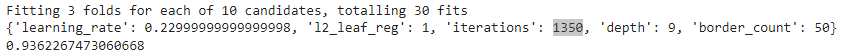

## Pipeline

In [ ]:
df = pd.DataFrame(data)
df = df.drop(columns=['db', 'id', 'file_name'])
df['chanel'] = df['chanel'].astype(np.uint8) / 2
X = df.drop(['chanel', 'is_norm'], axis=1)
y = df['chanel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', CatBoostClassifier(iterations=1350, learning_rate=0.23, depth=9, verbose=0))
])
pipeline.fit(X_train.values, y_train.values)
y_pred = pipeline.predict(X_test.values)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1665
         1.0       0.93      0.94      0.93      1712
         2.0       0.93      0.94      0.94      2207
         3.0       0.97      0.94      0.95      1624

    accuracy                           0.95      7208
   macro avg       0.95      0.95      0.95      7208
weighted avg       0.95      0.95      0.95      7208



Функции выделения признаков для получения прогноза

In [16]:
def reduce_noise(audio, sample_rate):
  return nr.reduce_noise(y=audio, sr=sample_rate) # новая функция, мб заменить

In [18]:
# Функция для извлечения признаков
def extract_features(audio, sample_rate, channel):
    if channel is None:
        # моно
        audio = audio.mean(axis=0)
    elif channel < audio.shape[0]:
        # иначе извлекаем канал
        audio = audio[channel]

    # Удаление шума
    audio = reduce_noise(audio=audio, sample_rate=sample_rate)

    # Извлечение мелспектрограммы
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_features = np.mean(mel_spectrogram_db.T, axis=0)

    # Извлечение спектра Уэльса (PSD)
    freqs, psd = welch(audio, fs=sample_rate)

    # Объединение признаков в один вектор
    combined_features = np.hstack((mel_features, psd))

    return combined_features

Получение прогноза

In [21]:
file_path = '00000014.wav'
features = extract_features(file_path)
features = features.reshape(1, -1)
prediction = pipeline.predict(features)
prediction

array([[1.]])

Сохранение пайплайна

In [ ]:
import joblib

joblib.dump(pipeline, 'pipeline_sourse.pkl')

['pipeline1.pkl']

# Anomaly Model

In [28]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
!pip install catboost

Следующие модели обучены на стереоканальных данных, так как тип оборудования при обучении уже известен

In [31]:
data = pd.read_csv('data_stereo.csv')
df = pd.DataFrame(data)
df['chanel'] = df['chanel'].astype(np.uint8) / 2
df = df.drop(columns=['db', 'id', 'file_name'])

In [32]:
df.head()

,chanel,is_norm,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,psd120,psd121,psd122,psd123,psd124,psd125,psd126,psd127,psd128,psd129
0,2.0,0,-47.948257,-47.787823,-50.677807,-51.056347,-50.642200,-47.262320,-50.307500,-52.535046,...,5.590475e-22,4.916740e-22,4.383439e-22,3.900106e-22,3.671524e-22,3.685028e-22,1.603149e-21,5.598826e-21,1.053240e-19,1.929020e-19
1,2.0,0,-47.653893,-46.898930,-48.165012,-48.781370,-49.767147,-50.259747,-46.523174,-47.340405,...,4.207661e-22,4.161062e-22,4.875349e-22,7.649123e-22,2.061319e-21,1.246162e-20,1.813628e-19,6.339769e-19,3.258824e-18,5.048739e-18
2,2.0,0,-49.249584,-51.292560,-48.682080,-47.050465,-46.746360,-46.142620,-46.027264,-48.786396,...,5.125575e-21,4.693626e-21,4.598994e-21,5.295803e-21,9.270302e-21,4.278163e-20,5.889540e-19,2.038074e-18,1.045086e-17,1.617234e-17
3,2.0,0,-40.476955,-44.206287,-45.347150,-44.664326,-48.402660,-49.838005,-48.918080,-49.930378,...,9.551894e-23,1.035932e-22,1.359846e-22,2.802465e-22,8.225974e-22,5.120447e-21,7.629358e-20,2.643473e-19,1.369141e-18,2.124957e-18
4,2.0,0,-41.056520,-42.528350,-40.939606,-39.691414,-39.760780,-39.839165,-40.023190,-39.563930,...,7.190720e-21,6.369933e-21,5.727163e-21,5.282800e-21,5.246299e-21,8.021460e-21,5.752555e-20,1.908494e-19,9.917980e-19,1.541684e-18


Разделим датасет на 4 по каждому типу оборудования (канала) и сохраним в словарь

In [33]:
split_dfs = {chanel: group for chanel, group in df.groupby('chanel')}

In [34]:
split_dfs

{0.0:        chanel  is_norm       mel1       mel2       mel3       mel4       mel5  \
 13849     0.0        0 -39.449050 -39.635296 -40.141410 -40.552660 -42.891033   
 13850     0.0        0 -47.359367 -44.551180 -49.516415 -54.125150 -55.915054   
 13851     0.0        0 -42.059563 -34.980587 -40.258327 -44.739822 -45.562702   
 13852     0.0        0 -46.214863 -44.345436 -47.628372 -51.856285 -54.903378   
 13853     0.0        0 -47.897335 -44.699720 -47.212357 -51.051487 -52.874370   
 ...       ...      ...        ...        ...        ...        ...        ...   
 54052     0.0        1 -51.495594 -53.440390 -56.602260 -57.154247 -59.059437   
 54053     0.0        1 -52.218525 -53.832620 -56.597126 -58.744010 -60.175663   
 54054     0.0        1 -51.807426 -54.552685 -57.810974 -59.116997 -59.571472   
 54055     0.0        1 -49.996746 -51.025394 -54.774315 -59.680210 -60.488464   
 54056     0.0        1 -49.259780 -51.346252 -54.812500 -56.071346 -58.573208   
 
         

## Valve

In [ ]:
df_valve = split_dfs[0].drop(columns=['chanel'])
X = df_valve.drop(columns=['is_norm'])
y = df_valve['is_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', CatBoostClassifier(iterations=1000,
                                      learning_rate=0.1,
                                      depth=6,
                                      auto_class_weights='Balanced',
                                      verbose=0))
])

pipeline.fit(X_train.values, y_train.values)

y_pred = pipeline.predict(X_test.values)

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       1.00      1.00      1.00      2215

    accuracy                           1.00      2502
   macro avg       1.00      1.00      1.00      2502
weighted avg       1.00      1.00      1.00      2502



In [ ]:
joblib.dump(pipeline, 'pipeline_valve.pkl')

['pipeline_valve.pkl']

## Pump

In [ ]:
df_pump = split_dfs[1].drop(columns=['chanel'])
X = df_pump.drop(columns=['is_norm'])
y = df_pump['is_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [ ]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', CatBoostClassifier(iterations=1000,
                                      learning_rate=0.1,
                                      depth=6,
                                      auto_class_weights='Balanced',
                                      verbose=0))
])

pipeline.fit(X_train.values, y_train.values)

y_pred = pipeline.predict(X_test.values)

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       274
           1       0.98      0.99      0.99      2249

    accuracy                           0.98      2523
   macro avg       0.96      0.91      0.94      2523
weighted avg       0.98      0.98      0.98      2523



In [ ]:
joblib.dump(pipeline, 'pipeline_pump.pkl')

['pipeline_pump.pkl']

# Fan

In [ ]:
df_fan = split_dfs[2].drop(columns=['chanel'])
X = df_fan.drop(columns=['is_norm'])
y = df_fan['is_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', CatBoostClassifier(iterations=1000,
                                      learning_rate=0.1,
                                      depth=6,
                                      auto_class_weights='Balanced',
                                      verbose=0))
])

pipeline.fit(X_train.values, y_train.values)

y_pred = pipeline.predict(X_test.values)

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       885
           1       0.94      0.96      0.95      2445

    accuracy                           0.93      3330
   macro avg       0.91      0.90      0.90      3330
weighted avg       0.93      0.93      0.93      3330



In [ ]:
joblib.dump(pipeline, 'pipeline_fan.pkl')

['pipeline_fan.pkl']

# Slider

In [ ]:
df_slider = split_dfs[3].drop(columns=['chanel'])
X = df_slider.drop(columns=['is_norm'])
y = df_slider['is_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', CatBoostClassifier(iterations=1000,
                                      learning_rate=0.1,
                                      depth=6,
                                      auto_class_weights='Balanced',
                                      verbose=0))
])

pipeline.fit(X_train.values, y_train.values)

y_pred = pipeline.predict(X_test.values)

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       534
           1       1.00      1.00      1.00      1923

    accuracy                           1.00      2457
   macro avg       0.99      0.99      0.99      2457
weighted avg       1.00      1.00      1.00      2457



In [ ]:
joblib.dump(pipeline, 'pipeline_slider.pkl')

['pipeline_slider.pkl']